In [1]:
# Set the process name to be human readable in htop
import setproctitle
setproctitle.setproctitle("Run_Drug_Docking")

import requests
import pandas as pd
pd.options.display.max_columns = 999

import numpy as np
import helper as my

import glob
import os
import sys

from tqdm import tqdm, tqdm_notebook
from tqdm._tqdm_notebook import tqdm_notebook

tqdm.pandas(tqdm_notebook)
tqdm_notebook.pandas()


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

from mjm_tools import zip_res_range, unzip_res_range

from collections import defaultdict

import subprocess as sp
import time
from scipy.spatial import distance

# Paramaters for file locations

In [2]:
# Base directory for whole project
base_dir = "/home/sdw95/3D_SARS2"

# Parse and Clean Drug List

In [3]:
# Downloaded from Gordon et al Nature 2020 Supplemental Data
# https://static-content.springer.com/esm/art%3A10.1038%2Fs41586-020-2286-9/MediaObjects/41586_2020_2286_MOESM9_ESM.xlsx
drugs = pd.read_csv("{0}/Krogan_Drug_Candidates.txt".format(base_dir), sep="\t")

In [4]:
# Clean entries with multiple gene names in one row
# Based on manual inspection of all cases
rows = []
for row in drugs.values:
    row = list(row)
    
    # Simple case, multiple genes separated by slash
    if("/" in row[1]):
        targets = row[1].split("/")
        if(len(targets[1]) <= 2):
            targets = (targets[0], targets[0][:-1] + targets[-1])
            targets = [x if x != "EIF4EH" else "EIF4H" for x in targets]
        else:
            pass
    # Special case for genes separated by space
    elif(" " in row[1]):
        # Separate out "NUPs RAE1" entry to include
        # all NUP proteins + RAE1
        if("NUPs" in row[1]):
            targets = ['NUP210', 'NUP214', 'NUP62', 'NUP54', 'NUP88', 'NUP58', 'NUP98', 'RAE1']
        else:
            targets = [row[1]]
    # These are mostly groups of gene described by function (e.g. "Cell Entry")
    # We ignore these, but there are also a handful of genes with extra spaces
    # in the gene name.
    else:
        targets = [row[1].strip()]
    # Special case to interpret NDUFs as all NDUF Proteins
    if(targets == ["NDUFs"]):
        targets = ["NDUFAF2", "NDUFAF1", "NDUFB9"]
    
    # Flatten table for separate rows for all targets
    targets = set(my.flatten([x.strip().split("\n") for x in targets]))
    for t in targets:
        rows.append([row[0], t] + row[2:])
drugs = pd.DataFrame(rows, columns=list(drugs))

In [5]:
# Match by human interacting gene name
interactions = pd.read_csv("{0}/COVID19_Interactome.txt".format(base_dir), sep="\t")

m = drugs.join(interactions.set_index("PreyGene"), on="Human Gene", how="left")

# Select / Rename columns and save
m = m[["Compound Name", "Human Gene", "Preys", "Bait", "Structures (PDB)", "Drug Status", "Activity Description", "Activity Description.1", "Reference", "Smiles", "ZINC_ID", "Purchase notes", "Source"]]
m.columns = ["Compound Name", "Human Gene", "Human ID", "Viral ID", "Human PDBs", "Drug Status", "Activity Type", "Activity", "Reference", "Smiles", "ZINC_ID", "Purchase Notes", "Source"]

m.to_csv("{0}/Data/Krogan_Drug_Candidates.txt".format(base_dir), sep="\t", index=None)

# Generate PDB files for each ligand

In [22]:
if(not os.path.exists("{0}/Data/Ligands".format(base_dir))):
    os.mkdir("{0}/Data/Ligands".format(base_dir))
if(not os.path.exists("{0}/Data/Ligands/Images".format(base_dir))):
    os.mkdir("{0}/Data/Ligands/Images".format(base_dir))

In [23]:
for name, smiles in tqdm_notebook(drugs.drop_duplicates(["Compound Name"])[["Compound Name", "Smiles"]].values):
    # This SMILES String is improperly formatted. I looked up the "correct" string here...
    # https://www.medchemexpress.com/dBET6.html?src=google-product&gclid=EAIaIQobChMIqYf5m5ul6QIVT8DICh20VQh-EAAYASAAEgLmkPD_BwE
    if(name == "dBET6"):
        smiles = "O=C(NCCCCCCCCNC(COC1=CC=CC(C(N2C(CC3)C(NC3=O)=O)=O)=C1C2=O)=O)C[C@H]4C5=NN=C(C)N5C6=C(C(C)=C(C)S6)C(C7=CC=C(Cl)C=C7)=N4"
    
    # Use OpenBabel to create PDB File
    print os.system("obabel -:\"{0}\" --gen3d -opdb -O {1}/Data/Ligands/{2}.pdb -d".format(smiles, base_dir, name.replace("-", "_").replace(" ", "_").split("(")[0]))
    
    # Use OpenBabel to create 2D svg image of ligand
    print os.system("obabel -:\"{0}\" --gen3d -osvg -O {1}/Data/Ligands/Images/{2}.svg -d".format(smiles, base_dir, name.replace("-", "_").replace(" ", "_").split("(")[0]))
    #os.system("obabel -i pdb {0} -o pdb -O {0} -d".format(smiles, name.replace("-", "_").replace(" ", "_").split("(")[0]))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0



In [26]:
# Total Number of Potentially Dockable Examples
# with specific (viral-prot, human-prot, drug) pairs
# (Cases where Viral ID is NaN have non-specific human
# drug target specified (e.g. "Viral Transcription"))
len(m[~pd.isnull(m["Viral ID"])])

76

# Clean Undocked Structures for Docking

In [30]:
# Make sure there are no hydrogens in the protein structures
# used for docking
for f in tqdm_notebook(glob.glob("{0}/Data/Undocked_Structures/*".format(base_dir))):
    os.system("obabel -i pdb {0} -o pdb -O {0} -d".format(f))

# Run Ligand Docking

In [65]:
if(not os.path.exists("{0}/Data/Docked_Ligands".format(base_dir))):
    os.mkdir("{0}/Data/Docked_Ligands".format(base_dir))
if(not os.path.exists("{0}/Data/Docked_Ligands/sub_batches/".format(base_dir))):
    os.mkdir("{0}/Data/Docked_Ligands/sub_batches/".format(base_dir))
if(not os.path.exists("{0}/Data/Docked_Ligands/ranked_poses/".format(base_dir))):
    os.mkdir("{0}/Data/Docked_Ligands/ranked_poses/".format(base_dir))

In [39]:
# Read in list of drug pairs
drug_pairs = pd.read_csv("{0}/Data/Krogan_Drug_Candidates.txt".format(base_dir), sep="\t")

# Read in model info
models = pd.read_csv("{0}/Data/Models.txt".format(base_dir), sep="\t")

# Read in Protein info for total sequence length
proteins = pd.read_csv("{0}/Data/Proteins.txt".format(base_dir), sep="\t")
uni2seq = proteins.set_index("ID")["Sequence"].to_dict()

In [49]:
# Test loop for running docking with one process at a time
# NOTE: For now we just use this to get a summary of how
#       many docks will be run, and run the main batch
#       in parallel.

undockable = []
low_coverage = []
docked = []
for drug, uni in tqdm_notebook(drug_pairs[~pd.isnull(drug_pairs["Human ID"])][["Compound Name", "Human ID"]].values):
    drug = drug.replace("-", "_").replace(" ", "_").split("(")[0]
    
    # Grap Drug PDB
    drug_f = glob.glob("{0}/Data/Ligands/{1}*".format(base_dir, drug))[0]
    
    # Grab Human Protein PDB (skip if no PDB available)
    try:
        uni_f = glob.glob("{0}/Data/Undocked_Structures/{1}*".format(base_dir, uni))[0]
    except IndexError:
        print uni, drug
        undockable.append((drug, uni))
        continue
    
    # Check coverage of selected Human PDB
    # NOTE: Assumes only one Human Structure available for
    #       each protein
    total_len = len(uni2seq[uni])
    resi_covered = models[models["ID"] == uni]["Resi_Covered"].map(lambda x: len(unzip_res_range(x))).values[0]
    coverage = resi_covered / float(total_len)
    
    # If coverage is low, do not attempt docking
    # (would be inaccurate / bias predicted binding site)
    if(not coverage >= 0.33):
        low_coverage.append((drug, uni))
        continue
    docked.append((drug, uni))
    
    #print "smina -r {0} -l {1} --autobox_ligand {0} --autobox_add 10 -o {2}/Data/Docked_Ligands/{3}_{4}.pdb --exhaustiveness 8 --num_modes 10 --cpu 1".format(uni_f, drug_f, base_dir, uni, drug)
    #print os.system("smina -r {0} -l {1} --autobox_ligand {0} --autobox_add 10 -o {2}/Data/Docked_Ligands/{3}_{4}.pdb --exhaustiveness 8 --num_modes 10 --cpu 1".format(uni_f, drug_f, base_dir, uni, drug))
    #break

Q9Y680 Rapamycin_
Q9Y680 FK_506_



In [50]:
print len(undockable)
print len(low_coverage)
print len(docked)

2
38
36


In [ ]:
# Run Ligand Docking in Loop
# For the setup here we want to run N different docking trials for each drug-target pair
# producing up to 1000 docked conformations for each trial. We will then merge the results
# from all trials and retain the top N poses overall.
#
# Conceptually there should be no difference between repeating the same job N times, vs.
# just changing the exhaustiveness parameter to N*exhaustiveness (and possibly upping the
# num_mores parameter as well). We just do it in separate jobs here so that the results
# for each drug-target pair come in evenly.
#
# NOTE: I think the setup here might not be 100% safe for the server. While it's running
#       I start getting too many files open errors. (Mainly seems to break the running
#       JuPyter server)

i_num = 1
finished_processes = []
processes = []

max_processes = 5
# For this setup we will do 10 trials per drug-target pair. This could be set arbitrarilly
# high or low. From past experience, a single trial should be sufficient to obtain good docking
# results. We only increase the number of trials here for added roubustness.
for i_num in range(10):
    print "Docking Iteration", i_num
    
    # Iterate over all Docking Inputs
    for drug, uni in tqdm_notebook(drug_pairs[~pd.isnull(drug_pairs["Human ID"])][["Compound Name", "Human ID"]].values):
        # If this drug-target pair has already been docked on this iteration in the past, just skip it
        if(os.path.exists("{0}/Data/Docked_Ligands/sub_batches/{1}_{2}_{3}.pdb".format(base_dir, uni, drug, i_num))):
            continue
        
        # Grab Drug PDB
        drug = drug.replace("-", "_").replace(" ", "_").split("(")[0]
        drug_f = glob.glob("{0}/Data/Ligands/{1}*".format(base_dir, drug))[0]
        
        # Try to Grab Human PDB
        try:
            uni_f = glob.glob("{0}/Data/Undocked_Structures/{1}*".format(base_dir, uni))[0]
        except IndexError:
            print uni
            continue
        
        # Check coverage of selected Human PDB
        # NOTE: Assumes only one Human Structure available for
        #       each protein
        total_len = len(uni2seq[uni])
        resi_covered = models[models["ID"] == uni]["Resi_Covered"].map(lambda x: len(unzip_res_range(x))).values[0]
        coverage = resi_covered / float(total_len)
        
        # If coverage is low, do not attempt docking
        # (would be inaccurate / bias predicted binding site)
        if(not coverage >= 0.33):
            continue
        
        # Block new jobs if too many running already
        while(True):
            # If fewer than N (5) jobs running currently, submit next docking job
            if(len(processes) <= max_processes):
                cmd = "nice smina -r {0} -l {1} --autobox_ligand {0} --autobox_add 10 -o {2}/Data/Docked_Ligands/sub_batches/{3}_{4}_{5}_in_progress.pdb --exhaustiveness 40 --num_modes 1000 --cpu 5 --seed {5}".format(uni_f, drug_f, base_dir, uni, drug, i_num)
                p = sp.Popen(cmd, shell=True)
                processes.append({"p":p, "cmd":cmd, "start_time":time.time(), "end_time":None, "in":(drug, uni), "out_f":"{0}/Data/Docked_Ligands/sub_batches/{1}_{2}_{3}_in_progress.pdb".format(base_dir, uni, drug, i_num)})
                break
            
            # Otherwise wait until previous jobs have finished before starting a new docking job
            else:
                # Sleep for 30 seconds to give processes a change to finish
                time.sleep(30)
                
                # List of actively running processes (to be built)
                new_processes = []
                
                # Iterate over current process list
                for p in processes:
                    # If the process hasn't exited yet add it back
                    # into the list
                    if(p["p"].poll() is None):
                        new_processes.append(p)
                    # Otherwise, if exit code indicates and error
                    # print out error message
                    elif(p["p"].poll() != 0):
                        p["end_time"] = time.time()
                        print "Error", p["p"].poll()
                        print "cmd:", p["cmd"]
                        print "RunTime:", (p["end_time"] - p["start_time"])
                        print
                        finished_processes.append(p)
                    # otherwise, process finished successfully
                    # Print out total run-time
                    else:
                        p["end_time"] = time.time()
                        print "Finished Docking", p["in"], "in", (p["end_time"] - p["start_time"])
                        os.system("mv {0} {1}".format(p["out_f"], p["out_f"].replace("_in_progress", "")))
                        finished_processes.append(p)
                
                # Update active process list
                processes = new_processes

Docking Iteration 0


Q9Y680
Q9Y680
21/|/ 28%|| 21/76 [00:20<00:52,  1.05it/s]Error 1
cmd: nice smina -r /home/sdw95/3D_SARS2/Data/Undocked_Structures/Q8TEM1_f9f9fdc761e4f6082b496b5c06f0778e.pdb -l /home/sdw95/3D_SARS2/Data/Ligands/Verdinexor.pdb --autobox_ligand /home/sdw95/3D_SARS2/Data/Undocked_Structures/Q8TEM1_f9f9fdc761e4f6082b496b5c06f0778e.pdb --autobox_add 10 -o /home/sdw95/3D_SARS2/Data/Docked_Ligands/sub_batches/Q8TEM1_Verdinexor_0_in_progress.pdb --exhaustiveness 40 --num_modes 1000 --cpu 5 --seed 0
RunTime: 30.0467140675

Finished Docking ('Chloroquine', 'Q99720') in 90.2327830791
Finished Docking ('Verdinexor', 'Q99567') in 180.284098864
Finished Docking ('Verdinexor', 'P78406') in 180.281339884
Finished Docking ('Zotatifin_', 'O60573') in 240.358707905
Finished Docking ('Zotatifin_', 'Q15056') in 240.38004899
Finished Docking ('E_52862', 'Q99720') in 90.1459751129
Finished Docking ('Bafilomycin_A1', 'Q15904') in 150.278942823
Finished Docking ('Entacapone', 'P21964') in 90.1832931042
Finished

Q9Y680
Q9Y680
19/|/ 25%|| 19/76 [00:20<01:00,  1.05s/it]Finished Docking ('Chloroquine', 'Q99720') in 60.1590151787
Error 1
cmd: nice smina -r /home/sdw95/3D_SARS2/Data/Undocked_Structures/Q8TEM1_f9f9fdc761e4f6082b496b5c06f0778e.pdb -l /home/sdw95/3D_SARS2/Data/Ligands/Verdinexor.pdb --autobox_ligand /home/sdw95/3D_SARS2/Data/Undocked_Structures/Q8TEM1_f9f9fdc761e4f6082b496b5c06f0778e.pdb --autobox_add 10 -o /home/sdw95/3D_SARS2/Data/Docked_Ligands/sub_batches/Q8TEM1_Verdinexor_1_in_progress.pdb --exhaustiveness 40 --num_modes 1000 --cpu 5 --seed 1
RunTime: 30.041134119

Finished Docking ('Verdinexor', 'Q99567') in 180.279384851
Finished Docking ('Verdinexor', 'P78406') in 180.279301882
Finished Docking ('ZINC95559591', 'P27448') in 210.478615999
Finished Docking ('Zotatifin_', 'O60573') in 240.292335033
Finished Docking ('Bafilomycin_A1', 'Q15904') in 150.160057068
Finished Docking ('Zotatifin_', 'Q15056') in 240.316132069
Finished Docking ('E_52862', 'Q99720') in 90.160145998
Finishe

Finished Docking ('Ponatinib', 'Q13546') in 180.530934095
Finished Docking ('Valproic_Acid', 'Q92769') in 60.2208528519
Error 1
cmd: nice smina -r /home/sdw95/3D_SARS2/Data/Undocked_Structures/Q9H773_343f792499fe2ee667308c91dba97ffb.pdb -l /home/sdw95/3D_SARS2/Data/Ligands/ZINC4326719.pdb --autobox_ligand /home/sdw95/3D_SARS2/Data/Undocked_Structures/Q9H773_343f792499fe2ee667308c91dba97ffb.pdb --autobox_add 10 -o /home/sdw95/3D_SARS2/Data/Docked_Ligands/sub_batches/Q9H773_ZINC4326719_1_in_progress.pdb --exhaustiveness 40 --num_modes 1000 --cpu 5 --seed 1
RunTime: 30.1394879818

Error 1
cmd: nice smina -r /home/sdw95/3D_SARS2/Data/Undocked_Structures/Q9H773_343f792499fe2ee667308c91dba97ffb.pdb -l /home/sdw95/3D_SARS2/Data/Ligands/ZINC4511851.pdb --autobox_ligand /home/sdw95/3D_SARS2/Data/Undocked_Structures/Q9H773_343f792499fe2ee667308c91dba97ffb.pdb --autobox_add 10 -o /home/sdw95/3D_SARS2/Data/Docked_Ligands/sub_batches/Q9H773_ZINC4511851_1_in_progress.pdb --exhaustiveness 40 --num_mo

Q9Y680
Q9Y680
20/|/ 26%|| 20/76 [00:20<00:56,  1.00s/it]Error 1
cmd: nice smina -r /home/sdw95/3D_SARS2/Data/Undocked_Structures/Q9H773_343f792499fe2ee667308c91dba97ffb.pdb -l /home/sdw95/3D_SARS2/Data/Ligands/ZINC4511851.pdb --autobox_ligand /home/sdw95/3D_SARS2/Data/Undocked_Structures/Q9H773_343f792499fe2ee667308c91dba97ffb.pdb --autobox_add 10 -o /home/sdw95/3D_SARS2/Data/Docked_Ligands/sub_batches/Q9H773_ZINC4511851_2_in_progress.pdb --exhaustiveness 40 --num_modes 1000 --cpu 5 --seed 2
RunTime: 30.1817619801

Finished Docking ('Chloroquine', 'Q99720') in 90.1833019257
Error 1
cmd: nice smina -r /home/sdw95/3D_SARS2/Data/Undocked_Structures/Q8TEM1_f9f9fdc761e4f6082b496b5c06f0778e.pdb -l /home/sdw95/3D_SARS2/Data/Ligands/Verdinexor.pdb --autobox_ligand /home/sdw95/3D_SARS2/Data/Undocked_Structures/Q8TEM1_f9f9fdc761e4f6082b496b5c06f0778e.pdb --autobox_add 10 -o /home/sdw95/3D_SARS2/Data/Docked_Ligands/sub_batches/Q8TEM1_Verdinexor_3_in_progress.pdb --exhaustiveness 40 --num_modes 10

Q9Y680
Q9Y680
18/|/ 24%|| 18/76 [00:20<01:04,  1.11s/it]Error 1
cmd: nice smina -r /home/sdw95/3D_SARS2/Data/Undocked_Structures/Q9H773_343f792499fe2ee667308c91dba97ffb.pdb -l /home/sdw95/3D_SARS2/Data/Ligands/ZINC4511851.pdb --autobox_ligand /home/sdw95/3D_SARS2/Data/Undocked_Structures/Q9H773_343f792499fe2ee667308c91dba97ffb.pdb --autobox_add 10 -o /home/sdw95/3D_SARS2/Data/Docked_Ligands/sub_batches/Q9H773_ZINC4511851_3_in_progress.pdb --exhaustiveness 40 --num_modes 1000 --cpu 5 --seed 3
RunTime: 30.1908299923

Finished Docking ('Chloroquine', 'Q99720') in 90.2101309299
Error 1
cmd: nice smina -r /home/sdw95/3D_SARS2/Data/Undocked_Structures/Q8TEM1_f9f9fdc761e4f6082b496b5c06f0778e.pdb -l /home/sdw95/3D_SARS2/Data/Ligands/Verdinexor.pdb --autobox_ligand /home/sdw95/3D_SARS2/Data/Undocked_Structures/Q8TEM1_f9f9fdc761e4f6082b496b5c06f0778e.pdb --autobox_add 10 -o /home/sdw95/3D_SARS2/Data/Docked_Ligands/sub_batches/Q8TEM1_Verdinexor_4_in_progress.pdb --exhaustiveness 40 --num_modes 10

In [63]:
# Iterate over remaining processes to finish
# NOTE: The main reason this is necessary is because I rename
#       the output file after the process is fully done.
while(processes):
    # Sleep for 30 seconds to give processes a change to finish
    time.sleep(30)
    
    # List of actively running processes (to be built)
    new_processes = []
    
    # Iterate over current process list
    for p in processes:
        # If the process hasn't exited yet add it back
        # into the list
        if(p["p"].poll() is None):
            new_processes.append(p)
        # Otherwise, if exit code indicates and error
        # print out error message
        elif(p["p"].poll() != 0):
            p["end_time"] = time.time()
            print "Error", p["p"].poll()
            print "cmd:", p["cmd"]
            print "RunTime:", (p["end_time"] - p["start_time"])
            print
            finished_processes.append(p)
        # otherwise, process finished successfully
        # Print out total run-time
        else:
            p["end_time"] = time.time()
            print "Finished Docking", p["in"], "in", (p["end_time"] - p["start_time"])
            os.system("mv {0} {1}".format(p["out_f"], p["out_f"].replace("_in_progress", "")))
            finished_processes.append(p)
    
    # Update active process list
    processes = new_processes

Finished Docking ('Sanglifehrin_A', 'P12268') in 1239.91199112
Finished Docking ('Ponatinib', 'Q13546') in 608.596369028
Finished Docking ('Valproic_Acid', 'Q92769') in 488.308521032
Error 1
cmd: nice smina -r /home/sdw95/3D_SARS2/Data/Undocked_Structures/Q9H773_343f792499fe2ee667308c91dba97ffb.pdb -l /home/sdw95/3D_SARS2/Data/Ligands/ZINC4326719.pdb --autobox_ligand /home/sdw95/3D_SARS2/Data/Undocked_Structures/Q9H773_343f792499fe2ee667308c91dba97ffb.pdb --autobox_add 10 -o /home/sdw95/3D_SARS2/Data/Docked_Ligands/sub_batches/Q9H773_ZINC4326719_9_in_progress.pdb --exhaustiveness 40 --num_modes 1000 --cpu 5 --seed 9
RunTime: 458.229407072

Error 1
cmd: nice smina -r /home/sdw95/3D_SARS2/Data/Undocked_Structures/Q9H773_343f792499fe2ee667308c91dba97ffb.pdb -l /home/sdw95/3D_SARS2/Data/Ligands/ZINC4511851.pdb --autobox_ligand /home/sdw95/3D_SARS2/Data/Undocked_Structures/Q9H773_343f792499fe2ee667308c91dba97ffb.pdb --autobox_add 10 -o /home/sdw95/3D_SARS2/Data/Docked_Ligands/sub_batches/Q9

In [74]:
# Kill everything left just in case
for p in finished_processes:
    try:
        p["p"].terminate()
    except:
        pass

In [68]:
# Parse Ligand Docking Results
#
# Reads in all docking results from N independent trials and creates
# a ranked poses describing the top 100 scoring poses accross all
# trials for each drug-target pair. Also creates a single .pdb under
# docked_ligands that contains these 100 top poses in one .pdb
#
for drug, uni in tqdm_notebook(drug_pairs[~pd.isnull(drug_pairs["Human ID"])][["Compound Name", "Human ID"]].values):
    # Parse Inputs
    drug = drug.replace("-", "_").replace(" ", "_").split("(")[0]
    drug_f = glob.glob("{0}/Data/Ligands/{1}*".format(base_dir, drug))[0]
    
    try:
        uni_f = glob.glob("{0}/Data/Undocked_Structures/{1}*".format(base_dir, uni))[0]
    except IndexError:
        continue
    
    # Load all docking sub-batches
    outs = glob.glob("{0}/Data/Docked_Ligands/sub_batches/{1}_{2}_*.pdb".format(base_dir, uni, drug))
    
    if(len(outs) == 0):
        continue
    
    # Read in all docked poses
    model2data = dict()
    for out in outs:
        with open(out, "r") as f:
            for l in f:
                if(l[:6] == "MODEL "):
                    model = (out, int(l.strip().split()[-1]))
                    lines = ["MODELSTART\n"]
                    socre = 0
                    centroid = np.zeros(3)
                    n_atoms = 0
                elif(l[:6] == "REMARK"):
                    score = float(l.strip().split()[-1])
                    lines.append(l)
                elif(l[:6] == "COMPND"):
                    lines.append(l.replace("UNNAMED", drug.upper()))
                elif(l[:6] == "HETATM"):
                    lines.append(l)
                    centroid += np.array([float(l[30:38]), float(l[38:46]), float(l[46:54])])
                    n_atoms += 1
                elif(l[:6] == "END   "):
                    lines.append(l)
                elif(l[:6] == "ENDMDL"):
                    lines.append(l)
                    model2data[model] = (lines, score, centroid / float(n_atoms))
                else:
                    pass
    
    # Select top poses from "distinct" binding sites
    #out = open("Data/Docked_Ligands/{0}_{1}.pdb".format(uni, drug), "w+")
    model_num = 1
    cur_centroids = []
    out = open("{0}/Data/Docked_Ligands/{1}_{2}.pdb".format(base_dir, uni, drug), "w+")
    for k, v in sorted(model2data.iteritems(), key=lambda (k, v): v[1]):
        if(len(cur_centroids) == 0):
            out2 = open("{0}/Data/Docked_Ligands/ranked_poses/{1}_{2}_{3}.pdb".format(base_dir, uni, drug, model_num), "w+")
            out.write("".join(v[0]).replace("MODELSTART", "MODEL{0:>9}".format(model_num)))
            out2.write("".join(v[0]).replace("MODELSTART", "MODEL{0:>9}".format(model_num)))
            out2.close()
            model_num += 1
            cur_centroids.append(v[2])
        elif(min([distance.euclidean(v[2], x) for x in cur_centroids]) >= 1):
            out2 = open("{0}/Data/Docked_Ligands/ranked_poses/{1}_{2}_{3}.pdb".format(base_dir, uni, drug, model_num), "w+")
            out.write("".join(v[0]).replace("MODELSTART", "MODEL{0:>9}".format(model_num)))
            out2.write("".join(v[0]).replace("MODELSTART", "MODEL{0:>9}".format(model_num)))
            out2.close()
            model_num += 1
            cur_centroids.append(v[2])
        if(model_num > 100):
            break
    out.close()

In [32]:
if(not os.path.exists("{0}/Data/Docked_Ligands/For_Website/".format(base_dir))):
    os.mkdir("{0}/Data/Docked_Ligands/For_Website/".format(base_dir))

In [19]:
# List of drug name replacements to make
# (For website its for some reason more convenient
#  to have the file formatted to exactly match the drug
#  name in the drugs file)
rename = [["Zotatifin.pdb", "Zotatifin (eFT226).pdb"],
          ["E_52862.pdb", "E-52862.pdb"],
          ["Silmitasertib_.pdb", "Silmitasertib.pdb"],
          ["Bafilomycin_A1.pdb", "Bafilomycin A1.pdb"],
          ["PD_144418.pdb", "PD-144418.pdb"],
          ["Mycophenolic_acid.pdb", "Mycophenolic acid.pdb"],
          ["RS_PPCC.pdb", "RS-PPCC.pdb"],
          ["Sanglifehrin_A.pdb", "Sanglifehrin A.pdb"],
          ["H_89.pdb", "H-89.pdb"]]

# Iterate over all top-ranked ligand poses
for dock in glob.glob("{0}/Data/Docked_Ligands/ranked_poses/*_1.pdb".format(base_dir)):
    # Read in ligand PDB convert chain to C
    lig_pdb = my.pdb2df(dock)
    #lig_pdb["Data Type"] = "ATOM"
    lig_pdb["Chain"] = "C"
    
    # Identify receptor PDB and read in
    prot_f = glob.glob("{0}/Data/Undocked_Structures/{1}_*".format(base_dir, os.path.basename(dock).split("_")[0]))[0]
    prot_pdb = my.pdb2df(prot_f)
    
    # Concatenate the two PDBs
    merged_pdb = pd.concat([prot_pdb, lig_pdb])
    
    # Pull out original connectivity lines from the raw ligand PDB
    # (These lines are lost in the extraction process)
    orig_f = dock.replace("ranked_poses", "sub_batches".replace(".pdb", "_0.pdb"))
    #orig_f = "{0}/Data/Ligands/{1}.pdb".format(base_dir, "_".join(dock.split("/")[-1].split("_")[1:-1]))
    #print orig_f
    keep_lines = []
    with open(orig_f) as f:
        for l in f:
            if(not ("COMPND" in l or "AUTHOR" in l or "HETATM" in l or "REMARK" in l or "MODEL" in l)):
                keep_lines.append(l.strip())
            if("END" in l):
                break
    # Write parsed website-ready PDB files
    website_f = "{0}/Data/Docked_Ligands/For_Website/{1}".format(base_dir, os.path.basename(dock).replace("__", "_").replace("_1.pdb", ".pdb"))
    for s1, s2 in rename:
        website_f = website_f.replace(s1, s2)
    #print website_f
    my.df2pdb(website_f, merged_pdb)
    with open(website_f, "a+") as out:
        out.write("\n".join(keep_lines))

In [14]:
dock

'/home/sdw95/3D_SARS2/Data/Docked_Ligands/ranked_poses/Q99720_PB28_1.pdb'

In [13]:
!tail -n 100 /home/sdw95/3D_SARS2/Data/Docked_Ligands/sub_batches/P19784_Silmitasertib__0.pdb

HETATM   19  N   UNL     1     -31.780  17.819 -20.478  1.00  0.00           N  
HETATM   20  H   UNL     1     -32.593  18.276 -20.791  1.00  0.00           H  
HETATM   21  C   UNL     1     -31.330  16.703 -21.225  1.00  0.00           C  
HETATM   22  C   UNL     1     -30.028  16.214 -21.051  1.00  0.00           C  
HETATM   23  C   UNL     1     -29.587  15.083 -21.749  1.00  0.00           C  
HETATM   24  C   UNL     1     -30.453  14.409 -22.608  1.00  0.00           C  
HETATM   25  C   UNL     1     -31.760  14.864 -22.759  1.00  0.00           C  
HETATM   26 CL   UNL     1     -32.844  14.021 -23.795  1.00  0.00          Cl  
HETATM   27  C   UNL     1     -32.199  15.992 -22.067  1.00  0.00           C  
CONECT    1   16    2    6                                            
CONECT    2    1    3                                                 
CONECT    3    2    4                                                 
CONECT    4    3    5   14                                

In [19]:
!tail /home/sdw95/3D_SARS2/Data/Ligands/PB28.pdb


CONECT   20   19   21                                                 
CONECT   21   20   16                                                 
CONECT   22   19   23   27                                            
CONECT   23   22   24                                                 
CONECT   24   23   25                                                 
CONECT   25   24   26                                                 
CONECT   26   25   27                                                 
CONECT   27   26   22                                                 
MASTER        0    0    0    0    0    0    0    0   27    0   27    0
END


In [77]:
# Parse Ligand Docking Results
#
# Read in all scores accross all trials for each drug-target pair
#
pair2scores = dict()
for drug, uni in tqdm_notebook(drug_pairs[~pd.isnull(drug_pairs["Human ID"])][["Compound Name", "Human ID"]].values):
    # Parse Inputs
    drug = drug.replace("-", "_").replace(" ", "_").split("(")[0]
    drug_f = glob.glob("{0}/Data/Ligands/{1}*".format(base_dir, drug))[0]
    
    try:
        uni_f = glob.glob("{0}/Data/Undocked_Structures/{1}*".format(base_dir, uni))[0]
    except IndexError:
        continue
    
    # Load all docking sub-batches
    outs = glob.glob("{0}/Data/Docked_Ligands/sub_batches/{1}_{2}_*.pdb".format(base_dir, uni, drug))
    
    if(len(outs) == 0):
        continue
    
    scores = sorted(my.flatten([[float(x.split()[-1]) for x in my.call("grep minimizedAffinity " + out)] for out in outs]))
    
    pair2scores[(drug, uni)] = scores

('Midostaurin', 'Q7KZI7')
('Midostaurin', 'P27448')


{u'bodies': [<matplotlib.collections.PolyCollection at 0x2b131c8e95d0>,
 u'cbars': <matplotlib.collections.LineCollection at 0x2b131c4ef610>,
 u'cmaxes': <matplotlib.collections.LineCollection at 0x2b131c8e9b50>,
 u'cmins': <matplotlib.collections.LineCollection at 0x2b131d1fef50>}

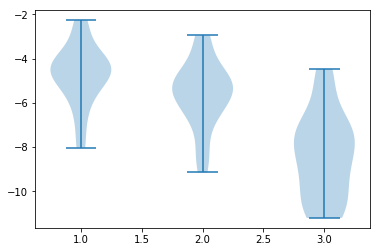

In [78]:
# Plot best, worst, and average score distributions
# (visual sanity check to make sure that the scores
#  are relatively improved for the top-scored pose)

best_scores = []
worst_scores = []
all_scores = []
for k in pair2scores:
    scores = pair2scores[k]
    if(len(scores) == 0):
        print k
        continue
    #plt.plot([x / float(len(scores)) for x in range(len(scores))], scores[::-1])
    best_scores.append(scores[0])
    worst_scores.append(scores[-1])
    all_scores.append(np.mean(scores))
plt.violinplot([worst_scores, all_scores, best_scores])

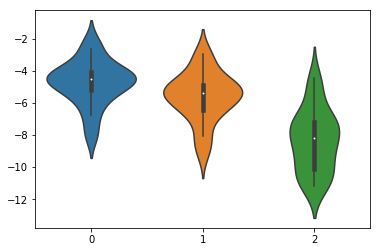

In [79]:
sns.violinplot(data=[worst_scores, all_scores, best_scores])

In [20]:
proteins = pd.read_csv("../Data/Proteins.txt", sep="\t")
s1 = set(proteins["ID"].values)
models = pd.read_csv("../Data/Models.txt", sep="\t")
s2 = models["ID"].values

In [21]:
print s1.difference(s2)

set(['Q9Y680', 'COVID19orf3b', 'COVID19orf10', 'Q96HR9', 'COVID19orf9c', 'COVID19M', 'COVID19nsp6', 'COVID19nsp4', 'COVID19nsp2', 'Q99996', 'P49454', 'Q8NCA5', 'COVID19orf6', 'COVID19nsp11'])
